<a href="https://colab.research.google.com/github/tteague19/xlab-security-course/blob/main/notebooks/01-fgsm_bim_pgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Adversarial Attacks

In [26]:
# IF YOU ARE IN COLAB OR HAVE NOT INSTALLED `xlab-security`
!pip install xlab-security # should not take more than a minute or two to run

In [27]:
import xlab
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

import torch
import matplotlib.pyplot as plt

# 1. Loading our "Tiny" Wideresnet Model

To save you time, we have pretrained a model for CIFAR-10 image classification. Our model scores ~83.86% on the CIFAR-10 test set. While this performance may appear to be somewhat low, it is actually a very good model for its size. If you are interested in exploring this model more or improving its performance, you can view our code [here](https://github.com/zroe1/xlab-ai-security/tree/main/models/adversarial_basics_cnn).

In [28]:
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

First let's take a look at what we have. We can see that we have 165,722 trainable parameters. This is actually quite small! Models trained on CIFAR-10 get many times larger. One model that we worked with during some of our initial tests had 36.5 million trainable pameters, making it over 200 times larger.

In [29]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 165,722


# 2. Loading and Processing Images

In future notebooks, you will be loading the CIFAR-10 dataset directly and benchmarking attacks on several images for different classes. For this notebook, to keep things simple, you will attack a single image: a cat belonging to one of our team members (his name is Thunderpaws). In a practical real world setting, when you are trying to use a model to classify a new image that was not originally in the train or test datasets, you first have to do some preprocessing.

### Task 2
Write a function that converts 'cat.jpg' into a transformed PyTorch tensor and resizes it to (32, 32). Two important considerations to be aware of:

1. You will not have to download `cat.jpg` from anywhere because it is automatically bundled with the `xlab` python package.
2. You will likely have to add a batch dimension to the image after applying a transformation. For assistance, you may reference the second hint for this task.

In [30]:
# for reference, you will always use the following utils to load images
# for this course
img = xlab.utils.load_sample_image('cat.jpg')
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x763 at 0x79FACA090AD0>


<details>
<summary>💡 <b>Hint for Task #2</b></summary>

    
In our solution we use:
```python
Compose([Transform1, Transform2])


```

</details>

<details>
<summary>💡 <b>Hint for Task #2</b></summary>

You will likely have to add a batch dimension to your image before returning it. In our solution we use:
```python
processedImg.unsqueeze(0)


```

</details>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python

def process_image(path):
    """
    Converts an image file to a scaled and normalized torch tensor ready for
    model input.

    Args:
        path (str): filepath to the image file to be processed

    Returns [1, 3, 32, 32]: processed image tensor with batch dimension,
        resized to 32x32 pixels and converted to tensor format
    """
    img = xlab.utils.load_sample_image(path)

    # 1. resize image and convert it to a tensor
    transform = Compose([Resize((32,32)), ToTensor()])
    processedImg = transform(img)

    # 2. ensure that you add a batch dimension of 1
    processedImg = processedImg.unsqueeze(0)

    
    return processedImg


```

</details>

In [31]:
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image

def process_image(path):
    """
    Converts an image file to a scaled and normalized torch tensor ready for
    model input.

    Args:
        path (str): filepath to the image file to be processed

    Returns [1, 3, 32, 32]: processed image tensor with batch dimension,
        resized to 32x32 pixels and converted to tensor format
    """
    img = xlab.utils.load_sample_image(path)

    ######### YOUR CODE STARTS HERE #########
    # 1. resize image and convert it to a tensor
    # 2. ensure that you add a batch dimension of 1

    transforms = Compose([Resize((32, 32)), ToTensor()])
    processed_image = transforms(img).unsqueeze(0)

    ########## YOUR CODE ENDS HERE ##########

    return processed_image

In [32]:
_ = xlab.tests.pgd.task2(process_image)


Running tests for Section 2.4.2, Task 2...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask2::test_valid_output PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask2::test_correct_output PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
======================== 2 passed, 2 warnings in 0.18s =============

Now let's take a look at the code you downloaded! If you are curious how to display a tensor as an image like this, you can reference our code for this utility function below.

<details>
<summary>🔦 <b>`show_image` implementation</b></summary>

```python

# xlab.utils.show_image
def show_image(img):
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0).detach().numpy())


```

</details>

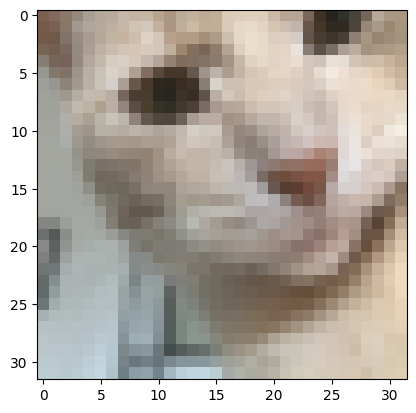

In [33]:
xlab.utils.show_image(process_image('cat.jpg'))

## 2a. Making Predictions

### Task 2a
Using the function you created above, predict what the model classifies the frog to be. The dataset we used to train the model is CIFAR 10, so the CNN will always produce one of the following categories:

<div align="center">
  <img src="https://xlabaisecurity.com/images/original_cifar_10.png" alt="CIFAR 10" width="500">
</div>

At the top of the notebook you can see we imported `itos` and `stoi` from the XLab python package. We use these functions in the cell below to convert the class index into the string label and vice versa:

```python
>>> itos[3]
'cat'
>>> stoi['cat']
3
```

For `Task 2`, you will implement the missing code below to generate predictions from the model. Then you will use your completed function and `process_image` to extract the predicted class and softmax probability for `'cat.jpg'`.

<details>
<summary>💡 <b>Hint for Task #2</b></summary>

    
Think carefully about what dimension you are taking the softmax over. In our code we have the following:

```python
probs = prediction.softmax(dim=-1)


```

</details>




</details>

<details>
<summary>🔐 <b>Solution for Task #2a</b></summary>

```python

def prediction(img):
    """
    Generates class prediction and confidence score for an input image tensor
    using the global model.

    Args:
        img [1, 3, 32, 32]: preprocessed image tensor with batch dimension

    Returns:
        pred_class (int): predicted class label as integer index
        pred_prob (float): confidence probability for the predicted class
    """
    with torch.no_grad(): #Stops calculating gradients
        prediction = model(img)
        
        probs = prediction.softmax(dim=-1) # softmax function used to calculate probabilities
        pred_class = torch.argmax(prediction, 1).item()
        pred_prob = probs[0][pred_class].item()

        return pred_class, pred_prob


# Use the above functions to predict 'frog.jpg'
path = 'cat.jpg'
pred, prob = prediction(process_image(path))
assert itos[pred] == 'cat'
print(f"For 'cat.jpg', the model predicts: '{itos[pred]}'")
```

</details>


In [38]:
def prediction(img):
    """
    Generates class prediction and confidence score for an input image tensor
    using the global model.

    Args:
        img [1, 3, 32, 32]: preprocessed image tensor with batch dimension

    Returns:
        pred_class (int): predicted class label as integer index
        pred_prob (float): softmax probability for the predicted class
    """
    with torch.no_grad(): # stops calculating gradients
        prediction = model(img)

        probs = prediction.softmax(dim=-1)
        pred_prob, pred_idx = torch.max(probs, 1)
        pred_class = pred_idx.item()
        pred_prob = pred_prob.item()

        return pred_class, pred_prob


# Use the above functions to predict 'cat.jpg'
path = 'cat.jpg'
pred, prob =  prediction(process_image(path))
assert itos[pred] == 'cat'
print(f"For 'cat.jpg', the model predicts: '{itos[pred]}'")

For 'cat.jpg', the model predicts: 'cat'


# 3. Making an adversarial image using FGSM
$ x' = x + \epsilon \cdot sign(\nabla loss_{F,t}(x))
$

### Task 3

The loss function, CrossEntropyLoss, has been loaded for you at the top of the cell below.

Using the above formula, complete the code for FGSM (Fast Gradient Sign Method). Find the loss for `'cat.jpg'` (using loss_fn) and calculate the gradient of this loss with respect to the image tensor. Find the signs of the gradient, and update the image accordingly to complete the attack.

<details>
<summary>💡 <b>Hint for Task #3</b></summary>

The following python example demonstrates how to find the gradient of the loss function with respect to the pixels in the image:
```python

img.requires_grad = True
out = model(img)
loss = loss_fn(out, y)
loss.backward()
grad = img.grad.data

```

</details>


<details>

<summary>🔐 <b>Solution for Task #3</b></summary>

```python

def FGSM_generator(model, loss_fn, path, y, epsilon=8/255):
    """
    Generates adversarial examples using the Fast Gradient Sign Method (FGSM)
    by adding noise in the direction of the gradient to fool the model.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): perturbation magnitude, defaults to 8/255

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        pixel values clamped between 0 and 1
    """

    # 1. Calculate the loss
    img = process_image(path)
    img.requires_grad = True
    out = model(img)
    print(out)
    loss = loss_fn(out, y)

    # 2. Calculate the gradient with respect to the input
    loss.backward()
    grad = img.grad.data

    img.requires_grad_(False) # no longer need to track gradient

    # 3. Perturb the image using the signs of the gradient
    img_adv = img + epsilon * torch.sign(grad)

    #4. Clamp the image between 0 and 1
    img_adv = torch.clamp(img_adv, 0, 1)
    
    return img_adv
        
```

</details>

In [43]:
loss_fn = torch.nn.CrossEntropyLoss()

def FGSM_generator(model, loss_fn, path, y, epsilon=8/255):
    """
    Generates adversarial examples using the Fast Gradient Sign Method (FGSM)
    by adding noise in the direction of the gradient to fool the model.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): perturbation magnitude, defaults to 8/255

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        pixel values clamped between 0 and 1
    """

    img = process_image(path)

    ######### YOUR CODE STARTS HERE #########
    # 1. calculate the loss
    # 2. calculate the gradient with respect to the input
    # 3. perturb the image using the signs of the gradient
    # 4. clamp the image between 0 and 1
    img.requires_grad = True

    output = model(img)
    loss = loss_fn(output, y)
    loss.backward()
    grad = img.grad.data

    img.requires_grad = False

    img_adv = img + epsilon * torch.sign(grad)
    img_adv = torch.clamp(img_adv, 0, 1)
    ########## YOUR CODE ENDS HERE ##########

    return img_adv

path = 'cat.jpg'
clean_class = prediction(process_image(path))[0]
x_adv_FGSM = FGSM_generator(model, loss_fn, path, torch.tensor([clean_class]))
pred, prob = prediction(x_adv_FGSM)
print(f"Prediction: {itos[pred]} with probability {prob:.2f}")

Prediction: dog with probability 0.65


In [44]:
_ = xlab.tests.pgd.task3(model, FGSM_generator)


Running tests for Section 2.4.2, Task 3...
🎉 All tests passed! (5/5)

Detailed output:
============================= test session starts ==============================
collecting ... collected 5 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask3::test_output_properties PASSED [ 20%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask3::test_perturbation_is_applied PASSED [ 40%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask3::test_epsilon_zero_produces_no_change PASSED [ 60%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask3::test_perturbation_within_epsilon_bound PASSED [ 80%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask3::test_output_adversarial PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__

Congratulations on completing your first ever attack! Now let's take a look at our adversarial image to see how suspicious it is. You should see that although it is visually different from the original, the image is still mostly unaltered and still depicts a cat.

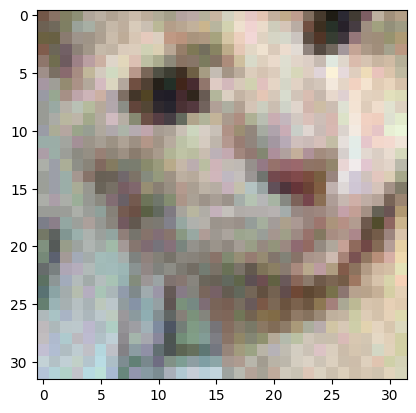

In [45]:
xlab.utils.show_image(x_adv_FGSM)

# 4. Making an adversarial image using BIM


### Task 4

Now that you have completed the FGSM function, completing BIM (Basic Iterative Method) should be mostly the same. The one potentially challenging part is making sure that you are clipping the image correctly. That's why first we ask you complete the helper function for clipping before moving on to the full BIM function.

For this function, you wil enforce that any perturbation in the image is not greater than $\epsilon$ difference from the original and that the image is always between 0 and 1. You can use the [torch.clamp](https://docs.pytorch.org/docs/stable/generated/torch.clamp.html) function for both of these requirements.

<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python

def clip(x, x_original, epsilon):
    """
    Clips adversarial perturbations to stay within epsilon-ball of original
    image and ensures valid pixel values between 0 and 1.

    Args:
        x (Tensor): perturbed image tensor to be clipped
        x_original (Tensor): original unperturbed image tensor
        epsilon (float): maximum allowed perturbation magnitude

    Returns [1, 3, 32, 32]: clipped image tensor with perturbations bounded
        by epsilon and pixel values clamped to [0, 1] range
    """
    
    x_final = None

    diff = x - x_original
    
    # 1. Clip x epsilon distance away
    diff = torch.clamp(diff, -epsilon, epsilon)
    x_clipped = x_original + diff

    # 2. Clip x between 0 and 1
    x_final = torch.clamp(x_clipped, 0, 1)

    return x_final

```

</details>

In [46]:
from torch import clamp

def clip(x, x_original, epsilon):
    """
    Clips adversarial perturbations to stay within epsilon-ball of original
    image and ensures valid pixel values between 0 and 1.

    Args:
        x (Tensor): perturbed image tensor to be clipped
        x_original (Tensor): original unperturbed image tensor
        epsilon (float): maximum allowed perturbation magnitude

    Returns [1, 3, 32, 32]: clipped image tensor with perturbations bounded
        by epsilon and pixel values clamped to [0, 1] range
    """

    ######### YOUR CODE STARTS HERE #########
    # 1. clip x epsilon distance away
    # 2. clip x between 0 and 1
    diff = x - x_original
    diff = torch.clamp(diff, -epsilon, epsilon)
    x_clipped = x_original + diff
    x_final = torch.clamp(x_clipped, 0, 1)
    ########## YOUR CODE ENDS HERE ##########

    return x_final

In [47]:
_ = xlab.tests.pgd.task4(clip)


Running tests for Section 2.4.2, Task 4...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4::test_clips_beyond_epsilon_ball PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4::test_clips_values_above_one PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4::test_clips_values_below_zero PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4::test_no_clipping_needed PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module a

### Task 4a

$ x'_i = \mathrm{clip}_\epsilon(x'_{i-1} + \alpha \cdot \mathrm{sign}(\nabla \mathrm{loss}_{F,t}(x'_{i-1})))
$

Using the above formula, complete the code for BIM. Your code will look similar to the function you implemented for FGSM.

<details>
<summary>💡 <b>Hint for Task #4a</b></summary>


The PyTorch operations that you will need to use to do clipping and to update the image you are optimizing will throw errors for a tensor that requires grad. For example, you may see an error that looks something like this:

```
RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
```

One way to work around this is to 'detach' the img tensor from the pytorch computational graph. In other words, this will remove gradient-tracking requirements and set `img.grad` to `None`.

```python
img = img.detach()
```


</details>



<details>
<summary>🔐 <b>Solution for Task #4a</b></summary>

```python

def BIM_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Generates adversarial examples using the Basic Iterative Method (BIM)
    by iteratively applying small gradient-based perturbations.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): maximum allowed perturbation magnitude, defaults to 8/255
        alpha (float): step size for each iteration, defaults to 0.01
        num_iters (int): number of iterative steps to perform, defaults to 6

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        perturbations bounded by epsilon and pixel values clamped to [0, 1]
    """
    
    img = process_image(path)
    original_img = img.clone()

    img = process_image(path)
    original_img = img.clone()

    # 1. loop num_iter times and complete 2-4 on each iteration
    for i in range(num_iters):
        img.requires_grad = True
        
        # 2. calculate the loss
        out = model(img)
        loss = loss_fn(out, y)
    
        # 3. calculate the gradient with respect to the input
        loss.backward()
        grad = img.grad.data
    
        # 4. perturb the image using the signs of the gradient
        img.requires_grad_(False)
        img += alpha * torch.sign(grad)

        #5. clamp the image within epsilon distance
        img = clip(img, original_img, epsilon)

    return img

```

</details>

In [53]:
def BIM_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Generates adversarial examples using the Basic Iterative Method (BIM)
    by iteratively applying small gradient-based perturbations.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): maximum allowed perturbation magnitude, defaults to 8/255
        alpha (float): step size for each iteration, defaults to 0.01
        num_iters (int): number of iterative steps to perform, defaults to 6

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        perturbations bounded by epsilon and pixel values clamped to [0, 1]
    """

    img = process_image(path)
    original_img = img.clone()

    ######### YOUR CODE STARTS HERE #########
    # 1. loop num_iter times and complete 2-4 on each iteration
    # 2. calculate the loss
    # 3. calculate the gradient with respect to the input
    # 4. perturb the image using the signs of the gradient
    # 5. clamp the image within epsilon distance

    for iter_num in range(num_iters):
        img.requires_grad = True

        output = model(img)
        loss = loss_fn(output, y)
        loss.backward()
        grad = img.grad.data

        img.requires_grad = False

        img += alpha * torch.sign(grad)
        img = clip(x=img, x_original=original_img, epsilon=epsilon)
    ######### YOUR CODE ENDS HERE #########

    return img

path = 'cat.jpg'
clean_class = prediction(process_image(path))[0]
x_adv_BIM = BIM_generator(model, loss_fn, path, torch.tensor([clean_class]))
pred, prob = prediction(x_adv_BIM)
print(f"Prediction: {itos[pred]} with probability {prob:.2f}")
print(f"Max difference in pixels = {torch.max(torch.abs(x_adv_BIM - process_image('cat.jpg'))).item():.4f}")

Prediction: dog with probability 1.00
Max difference in pixels = 0.0314


In [54]:
_ = xlab.tests.pgd.task4a(model, BIM_generator)


Running tests for Section 2.4.2, Task 4a...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4a::test_output_properties PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4a::test_perturbation_is_applied PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4a::test_epsilon_zero_produces_no_change PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask4a::test_output_adversarial PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Mo

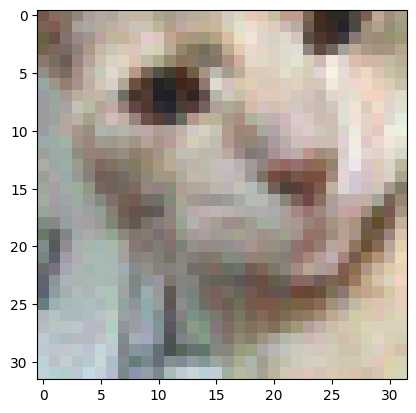

In [55]:
xlab.utils.show_image(x_adv_BIM)

# 5. Making an adversarial image using PGD

PGD is almost identical to BIM, with the only difference being that in PGD, we start with some noise added to our original image.

### Task 5
Implement PGD. You should use the `add_noise` helper below in addition to the `clip` helper you implemented above.

<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def PGD_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Generates adversarial examples using Projected Gradient Descent (PGD)
    by starting with noisy initialization and iteratively applying gradient-based perturbations.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): maximum allowed perturbation magnitude, defaults to 8/255
        alpha (float): step size for each iteration, defaults to 0.01
        num_iters (int): number of iterative steps to perform, defaults to 6

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        perturbations bounded by epsilon and pixel values clamped to [0, 1]
    """
    
    img = process_image(path)
    original_img = img.clone()

    # 1. add noise to initial image
    img = add_noise(img)
    
    # 2. loop num_iter times and complete 2-4 on each iteration
    for i in range(num_iters):
        img.requires_grad = True
        
        # 3. calculate the loss
        out = model(img)
        loss = loss_fn(out, y)
    
        # 4. calculate the gradient with respect to the input
        loss.backward()
        grad = img.grad.data
    
        # 5. perturb the image using the signs of the gradient
        img.requires_grad_(False)
        img += alpha * torch.sign(grad)

         # 6. clamp the image within epsilon distance
        img = clip(img, original_img, epsilon)

    return img

```

</details>

In [56]:
def add_noise(img, stdev=0.001, mean=0):
    """
    Adds Gaussian noise to an input image tensor for use in adversarial
    attack initialization or data augmentation.

    Args:
        img (Tensor): input image tensor to add noise to
        stdev (float): standard deviation of Gaussian noise, defaults to 0.001
        mean (float): mean of Gaussian noise distribution, defaults to 0

    Returns [same as input]: noisy image tensor with added Gaussian noise
        sampled from N(mean, stdev²)
    """
    noise = torch.randn_like(img) * stdev + mean
    return img + noise

def PGD_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Generates adversarial examples using Projected Gradient Descent (PGD)
    by starting with noisy initialization and iteratively applying gradient-based perturbations.

    Args:
        model: PyTorch model used for classification
        loss_fn: loss function for computing gradients
        path (str): filepath to the input image
        y (Tensor): true class label tensor for the image
        epsilon (float): maximum allowed perturbation magnitude, defaults to 8/255
        alpha (float): step size for each iteration, defaults to 0.01
        num_iters (int): number of iterative steps to perform, defaults to 6

    Returns [1, 3, 32, 32]: adversarially perturbed image tensor with
        perturbations bounded by epsilon and pixel values clamped to [0, 1]
    """

    img = process_image(path)
    original_img = img.clone()

    ######### YOUR CODE STARTS HERE #########
    # 1. add noise to initial image
    # 2. loop num_iter times and complete 2-4 on each iteration
    # 3. calculate the loss
    # 4. calculate the gradient with respect to the input
    # 5. perturb the image using the signs of the gradient
    # 6. clamp the image within epsilon distance
    img = add_noise(img=img)

    for iter_num in range(num_iters):
        img.requires_grad = True

        output = model(img)
        loss = loss_fn(output, y)
        loss.backward()
        grad = img.grad.data

        img.requires_grad = False

        img += alpha * torch.sign(grad)
        img = clip(x=img, x_original=original_img, epsilon=epsilon)

    ########## YOUR CODE ENDS HERE ##########

    return img

path = 'cat.jpg'
clean_class = prediction(process_image(path))[0]
x_adv_PGD = PGD_generator(model, loss_fn, path, torch.tensor([clean_class]))
pred, prob = prediction(x_adv_PGD)
print(f"Prediction: {itos[pred]} with probability {prob:.2f}")
print(f"Max difference in pixels = {torch.max(torch.abs(x_adv_PGD - process_image('cat.jpg'))).item():.4f}")

Prediction: dog with probability 1.00
Max difference in pixels = 0.0314


In [57]:
_ = xlab.tests.pgd.task5(model, PGD_generator)


Running tests for Section 2.4.2, Task 5...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask5::test_output_properties PASSED [ 25%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask5::test_perturbation_is_applied PASSED [ 50%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask5::test_epsilon_zero_produces_change PASSED [ 75%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask5::test_output_adversarial PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module alr

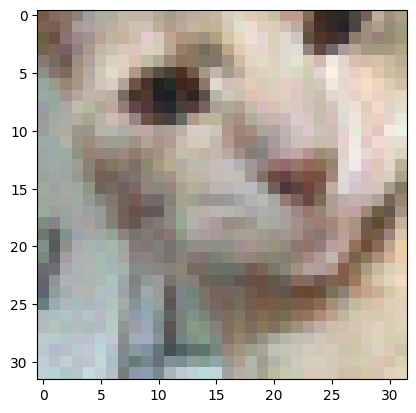

In [58]:
xlab.utils.show_image(x_adv_PGD)

# 6. Evaluating the distance

Now, we will evaluate the distance between the original image and the adversarial images.

### Task 6
The formula below finds the $L_p$ norm of a vector:

$
\|v\|_p = \left( \sum_{i=1}^{n} |v_i|^p \right)^{\frac{1}{p}}.
$


For our purposes, $v_i$ is the difference between a value in the input image and the adversarially perturbed image.

In our notebook, we have been constraining our adversarial image within the $L_\infty$ norm where our $L_\infty$ budget is $8/255$. The $L_\infty$ norm should be equal to the maximum absolute difference from the original image. Theoretically, the $L_p$ norm should converge to the $L_\infty$ norm as $p$ approaches infinity. This means that the value of the $L_\infty$ norm should be at or below $8/255$ for any adversarial image in this notebook. However, you likely won't observe this convergence when testing large $p$ values due to numerical instability. We'll address this issue in after this task`.

<details>
<summary>🔐 <b>Solution for Task #6</b></summary>

```python

def distance(x1, x2, p):
    """
    Calculates the Lp norm distance between two tensors, commonly used
    for measuring perturbation magnitude in adversarial attacks.

    Args:
        x1 (Tensor): first input tensor
        x2 (Tensor): second input tensor  
        p (int): norm order (e.g., 1 for L1 norm, 2 for L2 norm)

    Returns (float): Lp norm distance between x1 and x2
    """
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

```

</details>

In [59]:
def distance(x1, x2, p):
    """
    Calculates the Lp norm distance between two tensors, commonly used
    for measuring perturbation magnitude in adversarial attacks.

    Args:
        x1 (Tensor): first input tensor
        x2 (Tensor): second input tensor
        p (int): norm order (e.g., 1 for L1 norm, 2 for L2 norm)

    Returns (float): Lp norm distance between x1 and x2
    """
    return (x2 - x1).abs().pow(p).sum().pow(1/p)


In [60]:
_ = xlab.tests.pgd.task6(distance)


Running tests for Section 2.4.2, Task 6...
🎉 All tests passed! (3/3)

Detailed output:
============================= test session starts ==============================
collecting ... collected 3 items

../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask6::test_l1_norm PASSED [ 33%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask6::test_l2_norm PASSED [ 66%]
../usr/local/lib/python3.12/dist-packages/xlab/tests/pgd.py::TestTask6::test_multi_dimensional_tensor_summation PASSED [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pyte

Below we calculate the $L_2$ norm for `x_adv_FGSM`, `x_adv_BIM` and `x_adv_PGD`. This should see a value ~1.6 or ~1.7 for each attack we ran.

In [61]:
x = xlab.utils.process_image('cat.jpg')
print(f"L2 Distance for FGSM: {distance(x, x_adv_FGSM, 2):.2f}")
print(f"L2 Distance for BIM: {distance(x, x_adv_BIM, 2):.2f}")
print(f"L2 Distance for PGD: {distance(x, x_adv_PGD, 2):.2f}")

L2 Distance for FGSM: 1.74
L2 Distance for BIM: 1.28
L2 Distance for PGD: 1.25


Below we calculate the $L_{\infty}$ norm for `x_adv_FGSM`, `x_adv_BIM` and `x_adv_PGD`. We don't use the distance function, but instead calculated it by hand, for reasons we will explain below.

If you did your attacks correctly, you should see a distance of ~0.0314.

In [62]:
l_inf_FGSM = torch.max(torch.abs(x_adv_FGSM - x)).item()
l_inf_BIM = torch.max(torch.abs(x_adv_BIM - x)).item()
l_inf_PGD = torch.max(torch.abs(x_adv_PGD - x)).item()

print(f"L infinity Distance for FGSM: {l_inf_FGSM:.4f}")
print(f"L infinity Distance for BIM: {l_inf_BIM:.4f}")
print(f"L infinity Distance for PGD: {l_inf_PGD:.4f}")

L infinity Distance for FGSM: 0.0314
L infinity Distance for BIM: 0.0314
L infinity Distance for PGD: 0.0314


# 6a. Numerical Stability

Unfortunately, our implementation of the  approach `distance` function lacks numerical stability as p goes to infinity. To mitigate this, the distance function can be tweaked slightly to allow for a more precise calculation.

For example, the below example goes to 0 instead of the L_inf norm of 0.0314.

In [63]:
print(distance(x, x_adv_BIM, 100))

tensor(0.)


Here is more numerically stable version of the function. It divides the difference tensor by its maximimum value before raising it to the power of p, before multiplying it back again, leading to greater robustness. Intuitively, this is because it makes every value lower than one, so there is no explosion with increasing powers.

In [64]:
def distance(x1, x2, p):
    """
    Calculates the Lp norm distance between two tensors, with
    additional edits for numerical stability.

    Args:
        x1 (Tensor): first input tensor
        x2 (Tensor): second input tensor
        p (int): norm order (e.g., 1 for L1 norm, 2 for L2 norm)

    Returns (float): Lp norm distance between x1 and x2
    """
    z = torch.max(abs(x1 - x2))
    x = (torch.abs(x1 - x2) / z) ** p
    x = torch.sum(x)
    return z * x ** (1/p)

The below demonstration shows how the L_norm of x and PGD converges to L_inf as p goes to infinity.

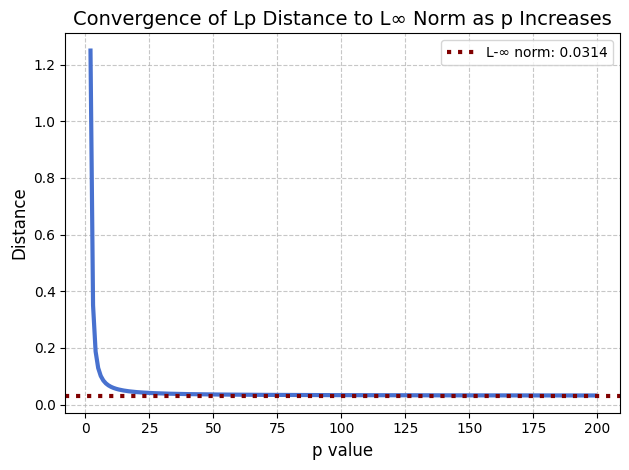

In [65]:
l_inf_norm = torch.max(torch.abs(x - x_adv_PGD)).item()
p_values = range(2,200)
distances = [distance(x, x_adv_PGD, p).item() for p in p_values]

plt.plot(p_values, distances, '#4871cf', linewidth=3, markersize=6)
plt.axhline(y=l_inf_norm, color='maroon', linestyle='dotted', linewidth=3, label=f'L-∞ norm: {l_inf_norm:.4f}')
# plt.yscale('log')  # Log scale for y-axis
plt.xlabel('p value', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Convergence of Lp Distance to L∞ Norm as p Increases', fontsize=14)
plt.grid(True, ls="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()